In [1]:
# Install required libraries
!pip install opencv-python scikit-learn matplotlib pillow -q

# Import libraries
import numpy as np
import pandas as pd
import cv2
import os
import zipfile
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [5]:
# We'll use Colab's local storage (/content/)
# No Google Drive needed!

import os
print("✓ Working in Colab local storage: /content/")
print("All files will be saved here temporarily")
print("Download results at the end using Cell 14")


✓ Working in Colab local storage: /content/
All files will be saved here temporarily
Download results at the end using Cell 14


In [6]:
# Upload kaggle.json file
from google.colab import files
print("📁 Upload your kaggle.json file:")
uploaded = files.upload()

# Setup Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("\n✓ Kaggle configured!")

# Download dataset
print("\n📥 Downloading dataset...")
!kaggle competitions download -c dogs-vs-cats

print("\n📦 Extracting files...")
!unzip -q train.zip
!unzip -q test1.zip

print("\n✓ Dataset ready!")

📁 Upload your kaggle.json file:


Saving kaggle.json to kaggle.json

✓ Kaggle configured!

📥 Downloading dataset...
 96% 776M/812M [00:10<00:00, 103MB/s] 
100% 812M/812M [00:10<00:00, 77.7MB/s]

📦 Extracting files...
unzip:  cannot find or open train.zip, train.zip.zip or train.zip.ZIP.
unzip:  cannot find or open test1.zip, test1.zip.zip or test1.zip.ZIP.

✓ Dataset ready!


In [9]:
!pip install kaggle


In [10]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"rahulheamanth","key":"3b189d6ad4cea63dfa32af29ff114f79"}'}

In [12]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mv: cannot stat 'kaggle.json': No such file or directory


In [13]:
!kaggle competitions download -c dogs-vs-cats


dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [17]:
!unzip -q dogs-vs-cats.zip
!unzip -q train.zip
!unzip -q test1.zip


replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace test1/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


📊 Total training images: 25000
🐱 Cats: 12500
🐶 Dogs: 12500


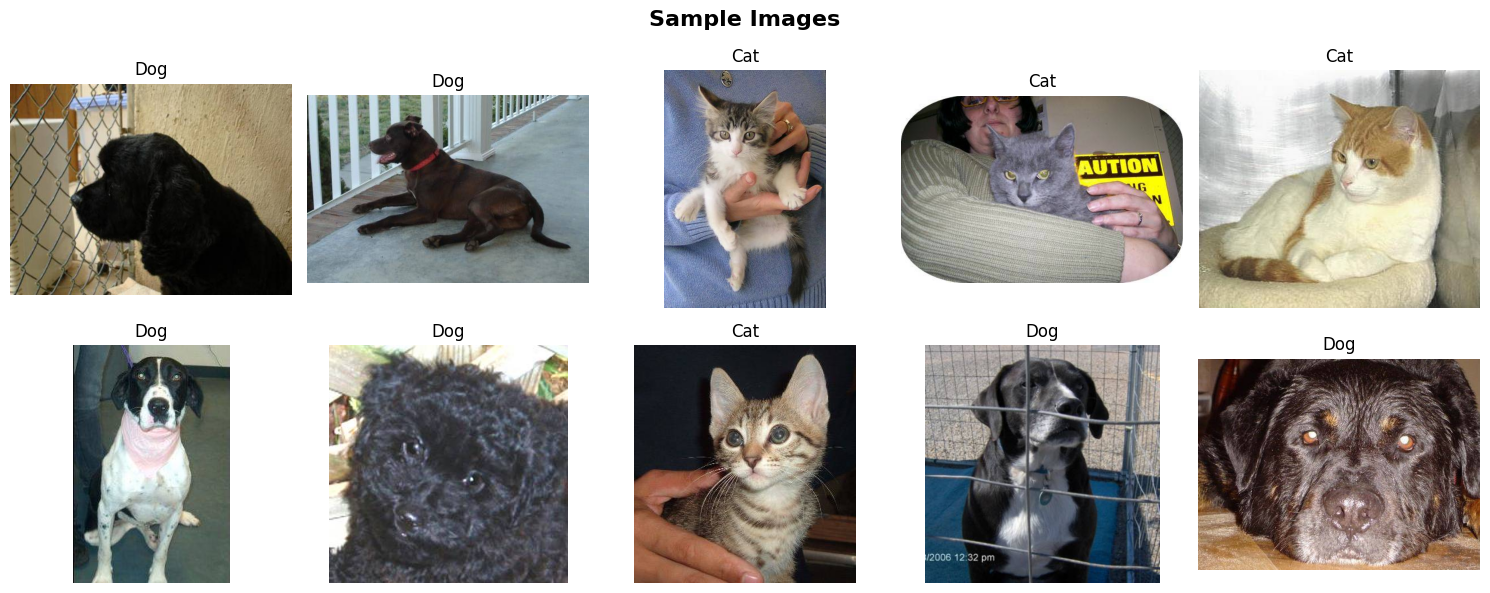

In [19]:
train_path = '/content/train'
test_path = '/content/test1'

train_files = os.listdir(train_path)
print(f"📊 Total training images: {len(train_files)}")

cat_count = len([f for f in train_files if f.startswith('cat')])
dog_count = len([f for f in train_files if f.startswith('dog')])

print(f"🐱 Cats: {cat_count}")
print(f"🐶 Dogs: {dog_count}")

# Display sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Images', fontsize=16, fontweight='bold')

for i in range(10):
    img_path = os.path.join(train_path, train_files[i])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    row = i // 5
    col = i % 5
    axes[row, col].imshow(img)
    axes[row, col].set_title(train_files[i].split('.')[0].capitalize())
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [21]:
IMG_SIZE = 64
MAX_IMAGES = 2000

def load_images(folder_path, max_images=2000):
    images = []
    labels = []
    files = os.listdir(folder_path)[:max_images]
    total = len(files)

    print(f"🔄 Loading {total} images...")

    for idx, filename in enumerate(files):
        if filename.endswith('.jpg'):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)

            if img is not None:
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_flat = img.flatten()
                images.append(img_flat)

                if filename.startswith('cat'):
                    labels.append(0)
                elif filename.startswith('dog'):
                    labels.append(1)

        if (idx + 1) % 500 == 0:
            print(f"  Processed {idx + 1}/{total} images...")

    print("✓ Loading completed!")
    return np.array(images), np.array(labels)

X, y = load_images(train_path, max_images=MAX_IMAGES)

print(f"\nData shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Cats: {np.sum(y == 0)}")
print(f"Dogs: {np.sum(y == 1)}")

🔄 Loading 2000 images...
  Processed 500/2000 images...
  Processed 1000/2000 images...
  Processed 1500/2000 images...
  Processed 2000/2000 images...
✓ Loading completed!

Data shape: (2000, 12288)
Labels shape: (2000,)
Cats: 966
Dogs: 1034


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} images")
print(f"Testing set: {X_test.shape[0]} images")

X_train = X_train / 255.0
X_test = X_test / 255.0

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Data preprocessing completed!")

Training set: 1600 images
Testing set: 400 images
✓ Data preprocessing completed!


In [24]:
print("🤖 Training SVM Model...")
print("⏳ This will take 2-5 minutes...\n")

import time
start_time = time.time()

svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42
)

svm_model.fit(X_train_scaled, y_train)

training_time = time.time() - start_time

print("✓ Training completed!")
print(f"Training time: {training_time:.2f} seconds")
print(f"Support vectors: {len(svm_model.support_)}")

🤖 Training SVM Model...
⏳ This will take 2-5 minutes...

✓ Training completed!
Training time: 33.85 seconds
Support vectors: 1515


In [25]:
y_pred_train = svm_model.predict(X_train_scaled)
y_pred_test = svm_model.predict(X_test_scaled)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, target_names=['Cat', 'Dog']))

cm = confusion_matrix(y_test, y_pred_test)
print("\nConfusion Matrix:")
print(cm)

Training Accuracy: 90.00%
Testing Accuracy: 60.25%

Classification Report:
              precision    recall  f1-score   support

         Cat       0.61      0.49      0.54       193
         Dog       0.60      0.71      0.65       207

    accuracy                           0.60       400
   macro avg       0.60      0.60      0.60       400
weighted avg       0.60      0.60      0.60       400


Confusion Matrix:
[[ 94  99]
 [ 60 147]]


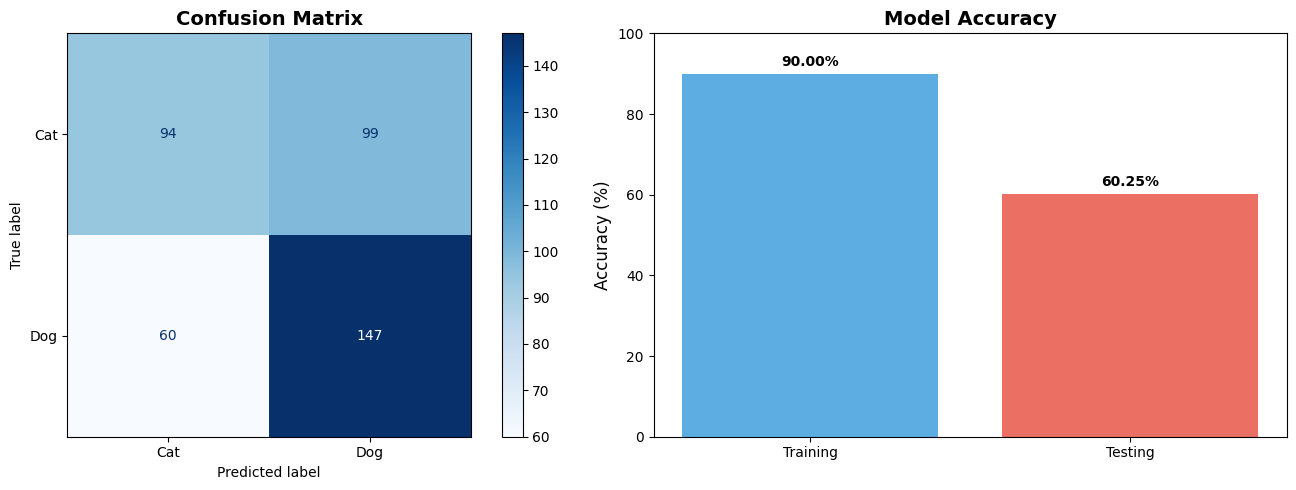

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cat', 'Dog'])
disp.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')

accuracies = [train_accuracy * 100, test_accuracy * 100]
colors = ['#3498db', '#e74c3c']
axes[1].bar(['Training', 'Testing'], accuracies, color=colors, alpha=0.8)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 100])

for i, v in enumerate(accuracies):
    axes[1].text(i, v + 2, f'{v:.2f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

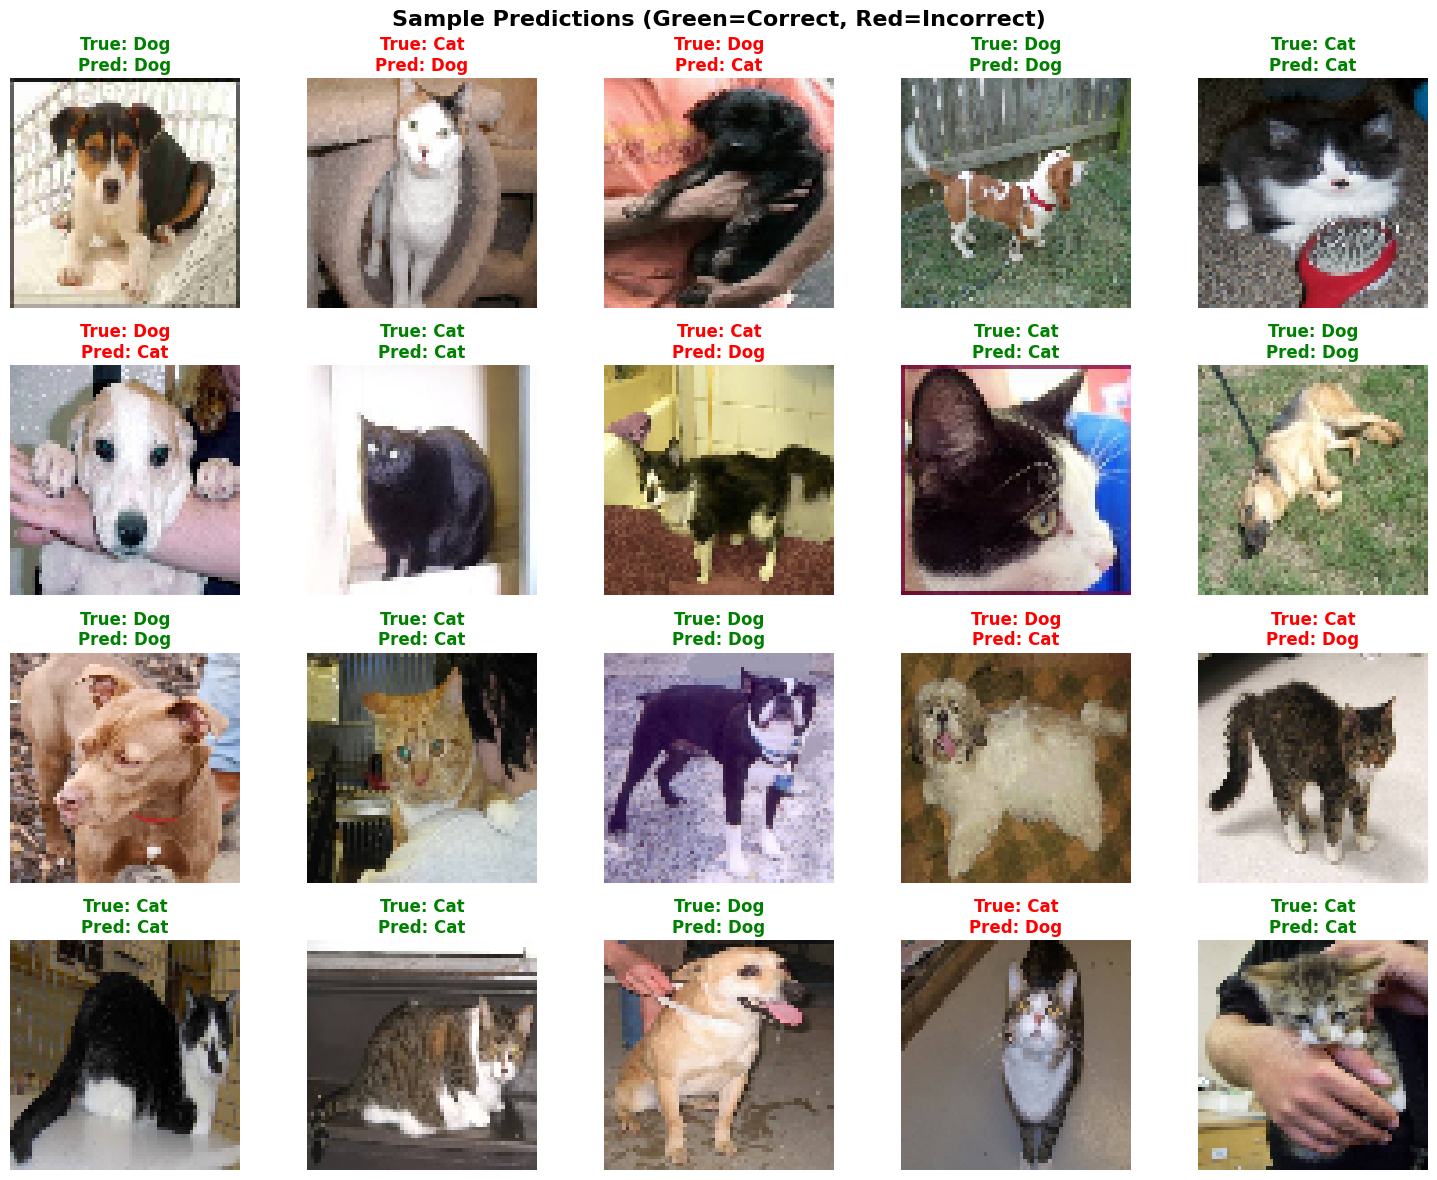

In [29]:
def visualize_predictions(X_test, y_test, y_pred, num_images=20):
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    fig.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)',
                 fontsize=16, fontweight='bold')

    indices = np.random.choice(len(X_test), num_images, replace=False)

    for i, idx in enumerate(indices):
        row = i // 5
        col = i % 5

        img = (X_test[idx] * 255).reshape(IMG_SIZE, IMG_SIZE, 3).astype(np.uint8)
        axes[row, col].imshow(img)

        true_label = 'Cat' if y_test[idx] == 0 else 'Dog'
        pred_label = 'Cat' if y_pred[idx] == 0 else 'Dog'
        color = 'green' if y_test[idx] == y_pred[idx] else 'red'

        axes[row, col].set_title(f"True: {true_label}\nPred: {pred_label}",
                                 color=color, fontweight='bold')
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.savefig('predictions_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_predictions(X_test, y_test, y_pred_test)

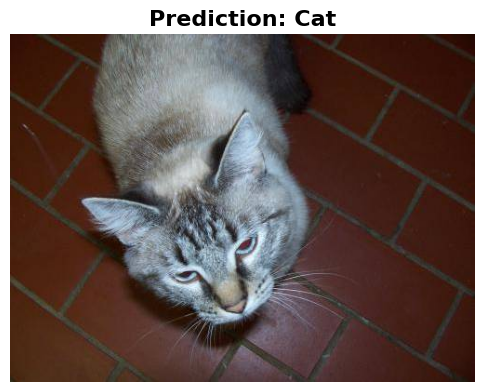

Predicted: Cat


In [31]:
def predict_single_image(image_path, model, scaler):
    img = cv2.imread(image_path)
    img_display = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_flat = img.flatten().reshape(1, -1)
    img_normalized = img_flat / 255.0
    img_scaled = scaler.transform(img_normalized)

    prediction = model.predict(img_scaled)[0]
    label = 'Cat' if prediction == 0 else 'Dog'

    plt.figure(figsize=(6, 6))
    plt.imshow(img_display)
    plt.title(f"Prediction: {label}", fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.show()

    return label

random_img = os.path.join(train_path, train_files[np.random.randint(0, len(train_files))])
result = predict_single_image(random_img, svm_model, scaler)
print(f"Predicted: {result}")

In [32]:
import pickle

with open('svm_cats_dogs_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("✓ Model saved!")

✓ Model saved!


In [33]:
print("="*70)
print("🎯 PROJECT SUMMARY REPORT")
print("="*70)

print(f"\n📊 Dataset:")
print(f"   Total images: {len(X)}")
print(f"   Training: {len(X_train)}")
print(f"   Testing: {len(X_test)}")

print(f"\n🤖 Model:")
print(f"   Algorithm: SVM with RBF kernel")
print(f"   Support vectors: {len(svm_model.support_)}")

print(f"\n📈 Performance:")
print(f"   Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"   Testing Accuracy: {test_accuracy * 100:.2f}%")
print(f"   Training Time: {training_time:.2f}s")

print("\n" + "="*70)
print("✅ Task 03 Completed!")
print("="*70)

🎯 PROJECT SUMMARY REPORT

📊 Dataset:
   Total images: 2000
   Training: 1600
   Testing: 400

🤖 Model:
   Algorithm: SVM with RBF kernel
   Support vectors: 1515

📈 Performance:
   Training Accuracy: 90.00%
   Testing Accuracy: 60.25%
   Training Time: 33.85s

✅ Task 03 Completed!


In [34]:
!zip -q results.zip model_evaluation.png predictions_visualization.png svm_cats_dogs_model.pkl scaler.pkl

from google.colab import files
files.download('results.zip')

print("✓ Results downloaded!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Results downloaded!
